This runs a joint, simultaneous fit of our HST/WFC3 G141 broadband light curve, a downloaded TESS light curve, and HARPS RV data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import batman
import emcee as mc
import corner
from astropy.io import fits
from multiprocessing import Pool
from scipy.optimize import newton
from scipy.stats import norm

import warnings
warnings.filterwarnings('ignore')

In [2]:
## Loading in the HST/WFC3 G141 broadband light curve
bbdata = np.load('/home/mmmurphy/data/hd219666b/reduced_data/Transit_Broad_Visit3_NoFirst.npz')
times_h = bbdata['time']
rawfluxes_h = bbdata['flux']
rawerrors_h = bbdata['error']
scandirs = bbdata['scandir']

# normalizing the flux and flux error values
fluxes_h, errors_h = np.copy(rawfluxes_h), np.copy(rawerrors_h)
sd1_idxs, sd0_idxs = np.where(scandirs == 1.)[0], np.where(scandirs == 0.)[0]
normval1, normval0 = np.median(rawfluxes_h[sd1_idxs]), np.median(rawfluxes_h[sd0_idxs])
fluxes_h[sd1_idxs] /= normval1
errors_h[sd1_idxs] /= normval1
fluxes_h[sd0_idxs] /= normval0
errors_h[sd0_idxs] /= normval0

# creating the relative time arrays
t_visit_h = times_h - times_h[0]  # time since start of visit [day]

orbit_ends = np.array([17, 34, 51]) # indeces separing each orbit (note: orbit1 excluded)
orbit2times = times_h[:orbit_ends[0]]
orbit3times = times_h[orbit_ends[0] : orbit_ends[1]]
orbit4times = times_h[orbit_ends[1] : orbit_ends[2]]
# From above, compute time since beginning of orbit for each
tinorbit2 = orbit2times - orbit2times[0]
tinorbit3 = orbit3times - orbit3times[0]
tinorbit4 = orbit4times - orbit4times[0]
t_orbit_h = np.concatenate((tinorbit2, tinorbit3, tinorbit4))


## Loading in the prepped TESS data, from my 'Preparing TESS Data' notebook
tessdata = np.load('/home/mmmurphy/data/hd219666b/reduced_data/shortened_TESS_lightcurve.npz')
times_t_readin = tessdata['times']
tvoid = np.copy(times_t_readin).astype(float)
times_t = np.array(tvoid)
fluxes_t = tessdata['fluxes']
errors_t = tessdata['errs']

## Loading in the HARPS rv data (data from Esposito et al, 2019)
harpsdata = np.load('/home/mmmurphy/data/hd219666b/rv_data/HARPS_RVdata.npz')
times_rv = harpsdata['times_bjdtdb']
vels_rv = harpsdata['rvs_kms']
errs_rv = harpsdata['rverrs_kms']

In [3]:
print('Timing Info -----------------------')
print('HST:')
print('Time of first scan: ', times_h[0])
print('Time of last scan: ', times_h[-1])
print('Number of scans total:', len(times_h))
print('N scans per orbit: ', len(orbit2times), len(orbit3times), len(orbit4times))
print('Avg. orbit duration [min]: ', np.mean([(orbit2times[-1]-orbit2times[0]),
                                       (orbit3times[-1]-orbit3times[0]),
                                       (orbit4times[-1]-orbit4times[0])
                                       ])*24.*60.)
print('TESS:')
print('N data points: ', len(times_t))
print('HARPS:')
print('N data points: ', len(times_rv))

print('Data Info ---------------------------')
print('HST:')
mean_err_h, sd_err_h = norm.fit(errors_h)
print('Mean flux uncertainty [ppm]: ', mean_err_h*1.e6)
print('Scatter in flux uncertainty [ppm]: ', sd_err_h*1.e6)
print('TESS:')
mean_err_t, sd_err_t = norm.fit(errors_t)
print('Mean flux uncertainty [ppm]: ', mean_err_t*1.e6)
print('Scatter in flux uncertainty [ppm]: ', sd_err_t*1.e6)
print('HARPS:')
mean_err_rv, sd_err_rv = norm.fit(errs_rv)
print('Mean velocity uncertainty [km/s]: ', mean_err_rv*1.e6)
print('Scatter in velocity uncertainty [km/s]: ', sd_err_rv*1.e6)

Timing Info -----------------------
HST:
Time of first scan:  2458799.8198642572
Time of last scan:  2458799.9847369217
Number of scans total: 51
N scans per orbit:  17 17 17
Avg. orbit duration [min]:  40.53322948515415
TESS:
N data points:  1146
HARPS:
N data points:  21
Data Info ---------------------------
HST:
Mean flux uncertainty [ppm]:  46.320335056486876
Scatter in flux uncertainty [ppm]:  0.11342163698902125
TESS:
Mean flux uncertainty [ppm]:  660.3049696423113
Scatter in flux uncertainty [ppm]:  0.0
HARPS:
Mean velocity uncertainty [km/s]:  1190.4761904761906
Scatter in velocity uncertainty [km/s]:  280.99273317965583


In [4]:
##
# Defining my parameter arrays (inits, priors, etc)

labels = np.asarray(['tc', 'log10P', 'log10a', 'cosi', 'RpRs_hst', 'amp1', 'amp2', 'tau1', 'tau2', 'slope', 'intcpt', 'RpRs_tess',
                    'sqrtecosw', 'sqrtesinw', 'K', 'gamma'])
### note, when RV data confirmed to work, change transit models to pull e and w from RV params rather than using fixed vals

# Priors
c = 1. / np.log(10.)
lit_tc, lit_tc_unc = 2458329.1996, 0.0012   # [day; bjd tdb]; esposito+ 2019
lit_P, lit_P_unc = 6.034460, 0.000011       # [day]; hellier?
lit_log10P, lit_log10P_unc = np.log10(lit_P), ((c*lit_P_unc)/lit_P)
lit_rprs, lit_rprs_unc = 0.04192, 0.00083   # [Rstar]; esposito+ 2019
lit_aRs, lit_aRs_unc = 13.27, 0.39              # [Rstar]; esposito+ 2019
lit_log10aRs, lit_log10aRs_unc = np.log10(lit_aRs), ((c*lit_aRs_unc)/lit_aRs)
lit_i, lit_i_unc = 86.38, 0.15              # [degrees]; esposito+ 2019
lit_cosi, lit_cosi_unc = np.cos(lit_i*(np.pi/180.)), np.sin(lit_i*(np.pi/180.))*(lit_i_unc*(np.pi/180.))
# RV parameters
lit_K, lit_K_unc = 6.17, 0.46           # [m/s]
lit_e = 0.
lit_w = 90.*(np.pi/180.)  # [radian]
lit_par1 = np.sqrt(lit_e)*np.cos(lit_w)         
lit_par2 = np.sqrt(lit_e)*np.sin(lit_w)
lit_gamma, lit_gamma_unc = -20.0976, 0.0004   # [km/s]

theta_init = np.asarray([
    # Shared orbital parameters 
    lit_tc,                      # 0 - conjunction time
    lit_log10P,                  # 1 - log10 Period
    lit_log10aRs,                # 2 - log10 semi-major axis
    lit_cosi,                    # 3 - cosine inclination
    # Planetary parameters
    0.0431,                    # 4 - HST radius
    # HST systematic parameters
    0.00165,                       # 5 - hook amplitude for orbit 2
    0.00139,                       # 6 - hook amplitude for orbit 3 and 4
    -0.0065,                       # 7 - hook timescale for orbit 2
    -0.0057,                       # 8 - hook timescale for orbit 3 and 4
    -0.00304,                       # 9 - ramp slope
    1.0008,                       # 10 - ramp intercept
    # TESS parameter
    lit_rprs,                    # 11 - TESS radius
    # RV parameters
    lit_par1,               # 12 - sqrt(e) cos(w)
    lit_par2,               # 13 - sqrt(e) sin(w)
    lit_K,                 # 14 - RV semi-amplitude [m/s]
    lit_gamma              # 15 - system velocity [km/s]
])
priors = np.asarray([
    # Shared orbital parameters 
    lit_tc,                      # 0 - conjunction time
    lit_log10P,             # 1 - log10 Period
    lit_log10aRs,             # 2 - log10 semi-major axis
    lit_cosi,  # 3 - cosine inclination
    # Planetary parameters
    np.inf,                      # 4 - HST radius
    # HST systematic parameters
    np.inf,                      # 5 - hook amplitude
    np.inf,                      # 6
    np.inf,
    np.inf,                      # 8 - hook timescales
    np.inf,
    np.inf,                       # 10 
    lit_rprs,                     # 11 - TESS radius
    lit_par1, # 14
    lit_par2, # 15
    lit_K,    # 16
    lit_gamma  # 17
])
# set those which shouldn't have a prior to have value of infinity

c = 1. / np.log(10.)
priorserr = np.asarray([
    # Shared orbital parameters 
    lit_tc_unc,                                          # 0 - conjunction time
    lit_log10P_unc,                            # 1 - log10 Period
    lit_log10aRs_unc,                                # 2 - log10 semi-major axis
    lit_cosi_unc,  # 3 - cosine inclination
    # Planetary parameters
    lit_rprs_unc,                                         # 4 - HST radius
    # HST systematic parameters
    1.e-4,                                            # 5 - orbit 3&4 hook amplitude
    1.e-4,                                             # 6 - orbit 3&4 hook timescale
    1.e-4,                                               # 7
    1.e-4,                                             # 8
    1.e-4,                                # 9
    1.e-4,                                # 10
    lit_rprs_unc,                            # 11 - TESS radius
    1.e-3,     # 14 sqrt(e) cos(w)
    1.e-3,     # 15 sqrt(e) sin(w)
    lit_K_unc,     # 16 K [m/s]
    lit_gamma_unc     # 17 gamma [km/s]
])  # note - update these to real lit uncertainties

# Initializing the BATMAN models
InitParams = batman.TransitParams()
InitParams.t0 = theta_init[0]      
InitParams.per = 10.**theta_init[1]
InitParams.a = 10.**theta_init[2]
InitParams.inc = np.arccos(theta_init[3])*(180./np.pi)
InitParams.rp = theta_init[4]
InitParams.ecc = 0.
InitParams.w = 90.
InitParams.limb_dark = 'quadratic'
InitParams.u = [0.16, 0.31]
BATMAN_HSTinitmodel = batman.TransitModel(InitParams, times_h)
BATMAN_TESSinitmodel = batman.TransitModel(InitParams, times_t)

In [5]:
##
# Defining my astrophysical models

def transit(theta, initmodel, telescope):
    # Transit Light curve model
    # Inputs:
    # theta = array of lightcurve parameters
    # initmodel = pre-initialized BATMAN model environment, which increases efficiency
    # telescope = toggle between using TESS and HST radius
    
    # Unpack input parameters
    tc = theta[0]       # time of conjunction [days]
    log10P = theta[1]   # log10( Period [days] )
    log10a = theta[2]   # log10( a / Rstar )
    cosi = theta[3]     # cosine(inclination [rad])
    if telescope == 'HST':
        rprstar = theta[4]
    elif telescope == 'TESS':
        rprstar = theta[11]
    par1 = theta[12]
    par2 = theta[13]
        
    # Transform input parameters to forms used by BATMAN
    P = 10.**(log10P)  # compute Period in [day]
    a = 10.**(log10a)  # compute a/Rstar
    inc = np.arccos(cosi)*(180./np.pi)  # Compute inclination in [deg]
    ecc = par1**2 + par2**2     # eccentricity
    omega = np.arctan2(par2, par1)  # argument of periapsis
    
    # Initialize batman parameters
    params = batman.TransitParams()
    params.t0 = tc             # transit midpoint [day]
    params.per = P    # log10 (period [day])
    params.rp = rprstar
    params.a = a      # log10 (semi major axis [Rstar])
    params.inc = inc  # cosine inclination [degrees]
    params.ecc = ecc
    params.w = omega
    params.limb_dark = 'quadratic'
    params.u = [0.16, 0.31]
    
    lightcurve = initmodel.light_curve(params)
    return lightcurve
##
# Defining my systematic models
def hook(theta, torbit):
    # Orbit-long charge trapping hook model for HST
    # Inputs:
    # theta = array of lightcurve parameters
    # torbit = time since start of corresponding orbit in units [day]
    
    amplitude2 = theta[5]
    amplitude3 = theta[6]
    tau2 = theta[7]
    tau3 = theta[8]
    
    hookcurve = np.zeros(len(torbit))
    hookcurve[:17] = 1. - amplitude2*np.exp(torbit[:17]/tau2)
    hookcurve[17:] = 1. - amplitude3*np.exp(torbit[17:]/tau3)
    return hookcurve

def ramp(theta, tvisit):
    # Visit-long linear model for flux in time
    # Inputs:
    # theta = array of lightcurve parameters
    # tvisit = time since start of visit in units [day]    
    slope = theta[9]
    intercept = theta[10]
    
    y = intercept + (slope*tvisit)
    return y

In [6]:
def timetrans_to_timeperi(tc, per, ecc, omega):
    """
    Convert Time of Transit to Time of Periastron Passage
    Args:
        tc (float): time of transit
        per (float): period [days]
        ecc (float): eccentricity
        omega (float): longitude of periastron (radians)

    Returns:
        float: time of periastron passage
        
    Copied from source code <https://radvel.readthedocs.io/en/latest/_modules/radvel/orbit.html#timetrans_to_timeperi>

    """
    try:
        if ecc >= 1:
            return tc
    except ValueError:
        pass

    f = np.pi/2 - omega
    ee = 2 * np.arctan(np.tan(f/2) * np.sqrt((1-ecc)/(1+ecc)))  # eccentric anomaly
    tp = tc - per/(2*np.pi) * (ee - ecc*np.sin(ee))      # time of periastron

    return tp

def ecc_anomaly_eqn(EA, ecc, M):
    f = EA - ecc*np.sin(EA) - M
    return f

def true_anomaly(theta, times):
    
    # Unpack parameters
    tc = theta[0]        # conjunction time [day]
    P = 10.**(theta[1])  # period [day]
    par1 = theta[12]      # sqrt(e) * cos(omega)
    par2 = theta[13]      # sqrt(e) * sin(omega)
    
    ecc = par1**2 + par2**2     # eccentricity
    w = np.arctan2(par2, par1)  # argument of periapsis
    
    # Compute time of periastron passage
    tp = timetrans_to_timeperi(tc, P, ecc, w)
    
    # Compute mean anomalies
    n =  (2. * np.pi) / P
    M = n*(times - tp)
    
    # Root-find to solve for eccentric anomaly
    EA = np.asarray([])
    for Mval in M:
        EAval = newton(ecc_anomaly_eqn, 75., args=(ecc, Mval))
        EA = np.append(EA, EAval)
    
    # Compute projections of true anomaly
    cosf = (np.cos(EA) - ecc) / (1. - ecc*np.cos(EA))
    sinf = (np.sin(EA) * np.sqrt(1. - ecc*ecc)) / (1. - ecc*np.cos(EA))
    
    # Compute true anomaly
    f = np.arctan2(sinf, cosf)
    
    return f

def radial_velocity(theta, times):
    
    # Unpack parameters
    par1 = theta[12]      # sqrt(e) * cos(omega)
    par2 = theta[13]      # sqrt(e) * sin(omega)
    K = theta[14]/1000.   # RV semi-amplitude (km/s)
    gamma = theta[15]     # RV system velocity offset (km/s)
    
    ecc = par1**2 + par2**2     # eccentricity
    w = np.arctan2(par2, par1)  # argument of periapsis
    
    
    f = true_anomaly(theta, times)
    
    arg = np.cos(w + f) + ecc*np.cos(w)
    v = K*arg + gamma
    
    return v

In [7]:
def logLikelihood(ydata, yerr, modely):
    lnL = 0.
    chi_array = ((ydata - modely) ** 2. / yerr ** 2.) + np.log(2. * np.pi * yerr ** 2.)
    lnL += -0.5 * np.sum(chi_array)
    
    return lnL

def logPriors(theta, priors, priorserr):
    
    # Limits on certain parameters
    #if not (0. <= theta[0] <= 1.): return -np.inf
    # compute priors
    lnP = 0.
    for i, priorval in enumerate(priors):
        if np.isinf(priorval):
            # If not applying a prior on a parameter, it's listed as inf in the array
            lnP += 0 #continue
        else:
            lnP += -(theta[i] - priorval) ** 2. / (2. * priorserr[i] ** 2.) - np.log(np.sqrt(2. * priorserr[i] **2. * np.pi))
            #-0.5*((priorval-theta[i])**2/(priorserr[i]**2)) - np.log(np.sqrt(2.*np.pi*priorserr[i]*priorserr[i]))
    return lnP


def lnPosterior(theta, time_hst, time_tess, time_rv, tvisit_hst, torbit_hst, 
                flux_hst, fluxerrs_hst, flux_tess, fluxerrs_tess,
                vels_rv, velerrs_rv,
                priors, priorserr,
               BATMAN_HSTinitmodel, BATMAN_TESSinitmodel):
    
    prior_array = np.copy(priors)
    priorerrs_array = np.copy(priorserr)
    flux_array_HST, unc_array_HST = flux_hst, fluxerrs_hst
    flux_array_TESS, unc_array_TESS = flux_tess, fluxerrs_tess
    vels_array_RV, unc_array_RV = vels_rv, velerrs_rv
    
    # Compute and check priors
    lnPrior_value = logPriors(theta, prior_array, priorerrs_array)
    if not np.isfinite(lnPrior_value):
        return -np.inf
    
    # Compute models
    HSTtransit = transit(theta, BATMAN_HSTinitmodel, telescope='HST')
    HSThook = hook(theta, torbit_hst)
    HSTramp = ramp(theta, tvisit_hst)
    HSTmodel = HSTtransit * HSThook * HSTramp
    
    TESStransit = transit(theta, BATMAN_TESSinitmodel, telescope='TESS')
    RVmodel = radial_velocity(theta, times_rv)

    # Compute likelihoods
    lnLikelihood_HST = logLikelihood(flux_array_HST, unc_array_HST, HSTmodel)
    lnLikelihood_TESS = logLikelihood(flux_array_TESS, unc_array_TESS, TESStransit)
    lnLikelihood_RV = logLikelihood(vels_array_RV, unc_array_RV, RVmodel)

    # Compute posterior
    lnPost = lnPrior_value + lnLikelihood_HST + lnLikelihood_TESS + lnLikelihood_RV
    
    if np.isnan(lnPost):
        return -np.inf
    else:
        return lnPost
    
def computeBIC(Nparams, Ndata, lnL):
    bic = Nparams*np.log(Ndata) - 2.*lnL
    return bic

Initial lnPosterior: 7249.243162821462


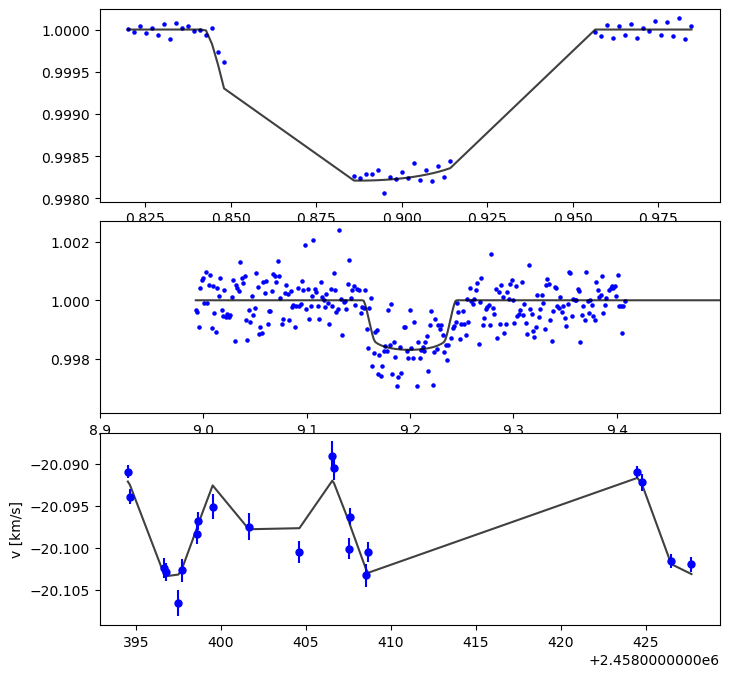

In [8]:
transit_model_HST = transit(theta_init, BATMAN_HSTinitmodel, 'HST')
transit_model_TESS = transit(theta_init, BATMAN_TESSinitmodel, 'TESS')
hook_model = hook(theta_init, t_orbit_h)
ramp_model = ramp(theta_init, t_visit_h)
sysHST = hook_model * ramp_model
modelHST = transit_model_HST * sysHST
modelTESS = transit_model_TESS
modelRV = radial_velocity(theta_init, times_rv)

lnPost_init = lnPosterior(theta_init, times_h, times_t, times_rv, t_visit_h, t_orbit_h, 
                fluxes_h, errors_h, fluxes_t, errors_t,
                vels_rv, errs_rv,
                priors, priorserr, BATMAN_HSTinitmodel, BATMAN_TESSinitmodel)
print('Initial lnPosterior:', lnPost_init)

fig, ax = plt.subplots(figsize=(8,8), nrows=3)
plt.subplots_adjust(hspace=0.1)
detflux_hst, deterr_hst = fluxes_h / sysHST, errors_h / sysHST
ax[0].plot(times_h, transit_model_HST, c='black', alpha=0.75)
ax[0].scatter(times_h, detflux_hst, c='blue', s=5)

ax[1].plot(times_t, modelTESS, c='black', alpha=0.75)
ax[1].scatter(times_t, fluxes_t, c='blue', s=5)
ax[1].set_xlim((lit_tc-.3), (lit_tc+.3))
#ax[1].axvline(lit_tc, c='gray', alpha=0.75)

ax[2].plot(times_rv, modelRV, c='black', alpha=0.75)
ax[2].errorbar(times_rv, vels_rv, errs_rv, 
               ls='None', marker='o', c='blue', ms=5)
ax[2].set(ylabel='v [km/s]')

plt.show()

In [11]:
######################################
# Setting up and initializing MCMC

Ndimensions = len(theta_init)
Nwalkers = 3*Ndimensions
burn = 5000
Nsteps = 50000 + burn
rerun = False
saveVals = False  # saves chains to file
storeVals = False # stores best fit array to ipython cache
loadChains = not rerun # set True if not rerunning

# Initializing walker positions
pos = np.zeros((Nwalkers, Ndimensions))

useStore = False
usePrev = True
if useStore:
    try:
        %store -r bb_paramfits
        %store -r bb_paramerrs
        for i in range(Ndimensions):
            pos[:,i] = bb_paramfits[i] + 0.5*np.random.normal(0., bb_paramerrs[i], Nwalkers)
        print('Initialized with stored values')
    except:
        try:
            # if we ran this before, initialize based on previous run's best fits
            for i in range(Ndimensions):
                pos[:,i] = param_fits[i] + 0.5*np.random.normal(0., param_uperrs[i], Nwalkers)
            print('Initialized with previous run')
        except:
            # if not, then use theta_init array
            for i in range(Ndimensions):
                pos[:,i] = theta_init[i] + 0.5*np.random.normal(0., priorserr[i], Nwalkers)
            print('Initialized from scratch')
else:
    if usePrev:
        try:
            # if we ran this before, initialize based on previous run's best fits
            for i in range(Ndimensions):
                pos[:,i] = param_fits[i] + 0.5*np.random.normal(0., param_uperrs[i], Nwalkers)
            print('Initialized with previous run')
        except:
            # if not, then use theta_init array
            for i in range(Ndimensions):
                pos[:,i] = theta_init[i] + 0.5*np.random.normal(0., priorserr[i], Nwalkers)
            print('Initialized from scratch')
    else:
       # if not, then use theta_init array
        for i in range(Ndimensions):
            pos[:,i] = theta_init[i] + 0.5*np.random.normal(0., priorserr[i], Nwalkers)
        print('Initialized from scratch')


Initialized with previous run


In [12]:
if rerun:
    with Pool() as pool: 
        sampler = mc.EnsembleSampler(Nwalkers, Ndimensions, lnPosterior, pool=pool,
                                    args=(times_h, times_t, times_rv, t_visit_h, t_orbit_h, 
                    fluxes_h, errors_h, fluxes_t, errors_t,
                    vels_rv, errs_rv,
                    priors, priorserr, BATMAN_HSTinitmodel, BATMAN_TESSinitmodel))
        sampler.run_mcmc(pos, Nsteps, progress=True);

In [13]:
if rerun:
    samples = sampler.get_chain()
    flatsamples = sampler.get_chain(flat=True)
    loglikelihoods = sampler.get_log_prob(flat=True)
    autocorrtimes = sampler.get_autocorr_time()

    samples = samples[burn:]
    flatsamples = flatsamples[burn*Nwalkers:]
    loglikelihoods = loglikelihoods[burn*Nwalkers:]
elif loadChains:
    path = '/home/mmmurphy/data/hd219666b/mcmc_results/jointfit/'
    sfile = path+'samples_50ksteps.npy'
    ffile = path+'flatsamples_50ksteps.npy'
    tfile = path+'autocorrtimes_50ksteps.npy'
    samples = np.load(sfile)
    flatsamples = np.load(ffile)
    autocorrtimes = np.load(tfile)
    print('chains loaded in from file in ', path)
    
param_fits = np.asarray([np.median(flatsamples[:,i]) for i in range(samples.shape[2])])
param_uperrs = np.asarray([np.percentile(flatsamples[:,i], 84) for i in range(samples.shape[2])]) - param_fits
param_loerrs = param_fits - np.asarray([np.percentile(flatsamples[:,i], 16) for i in range(samples.shape[2])])

# Generating models with best-fit parameters
bf_HSTtransit = transit(param_fits, BATMAN_HSTinitmodel, 'HST')
bf_TESStransit = transit(param_fits, BATMAN_TESSinitmodel, 'TESS')
bf_hook = hook(param_fits, t_orbit_h)
bf_ramp = ramp(param_fits, t_visit_h)
bf_HSTsys = bf_hook * bf_ramp
bf_HSTmodel = bf_HSTtransit * bf_HSTsys
bf_TESSmodel = bf_TESStransit
bf_RVmodel = radial_velocity(param_fits, times_rv)

detflux_h, deterrs_h = fluxes_h / bf_HSTsys, errors_h / bf_HSTsys


# Generating a smooth transit light curve with best-fit parameters for plotting purposes
times_h_smooth = np.linspace(times_h[0], times_h[-1], 100)
times_t_smooth = np.linspace(times_t[0], times_t[-1], 5000)
BFParams = batman.TransitParams()
BFParams.t0 = param_fits[0]      
BFParams.per = 10.**param_fits[1]
BFParams.a = 10.**param_fits[2]
BFParams.inc = np.arccos(param_fits[3])*(180./np.pi)
BFParams.rp = param_fits[4]
BFParams.ecc = 0.
BFParams.w = 90.
BFParams.limb_dark = 'quadratic'
BFParams.u = [0.33, 0.2]
BATMAN_HSTsmoothmodel = batman.TransitModel(BFParams, times_h_smooth)
transit_h_smooth = transit(param_fits, BATMAN_HSTsmoothmodel, 'HST')
BFParams.rp = param_fits[11]
BATMAN_TESSsmoothmodel = batman.TransitModel(BFParams, times_t_smooth)
transit_t_smooth = transit(param_fits, BATMAN_TESSsmoothmodel, 'TESS')

def phasefold(times, tc, per):
    phase = (times - tc)/per - np.floor((times-tc)/per)
    return phase

phase_rv = phasefold(times_rv, param_fits[0], 10.**(param_fits[1]))
RVsmoothtimes = np.linspace(min(times_rv), max(times_rv), 200, endpoint=True)
RVsmoothphase = phasefold(RVsmoothtimes, param_fits[0], 10.**(param_fits[1]))
RVsmoothmodel = radial_velocity(param_fits, RVsmoothtimes)
RVsortidxs = np.argsort(RVsmoothphase)
RVsmoothphase = RVsmoothphase[RVsortidxs]
RVsmoothmodel = RVsmoothmodel[RVsortidxs]


if storeVals:
    bb_paramfits = np.copy(param_fits)
    bb_paramerrs = np.copy(param_uperrs)
    %store bb_paramfits
    %store bb_paramerrs

if saveVals:
    path = '/home/mmmurphy/data/hd219666b/mcmc_results/jointfit/'
    sfile = path+'samples_50ksteps.npy'
    ffile = path+'flatsamples_50ksteps.npy'
    tfile = path+'autocorrtimes_50ksteps.npy'
    np.save(sfile, samples)
    np.save(ffile, flatsamples)
    np.save(tfile, autocorrtimes)
    print('chains saved to ', path)

chains loaded in from file in  /home/mmmurphy/data/hd219666b/mcmc_results/jointfit/


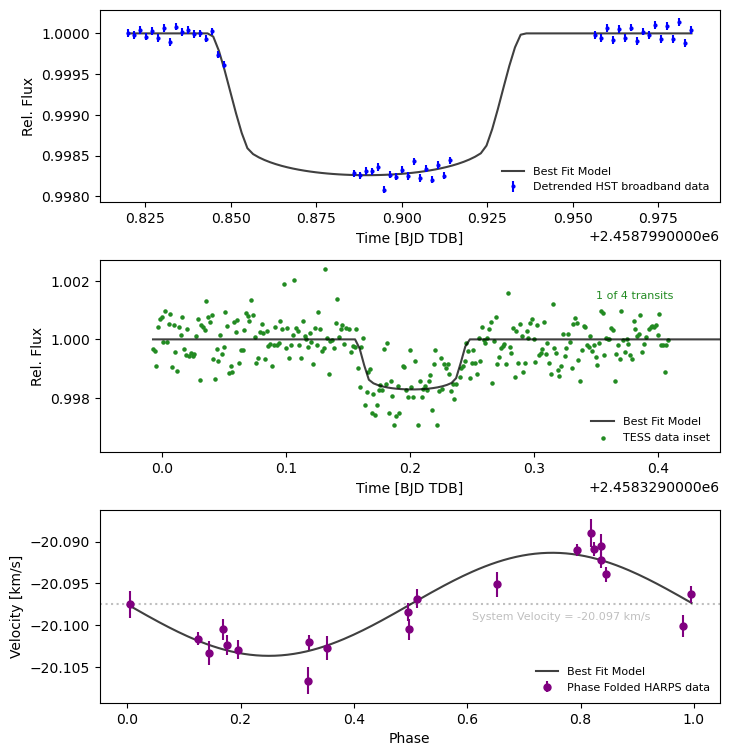

In [14]:
#lnPost_init = lnPosterior(theta_init)
#print('Initial lnPosterior:', lnPost_init)
fig, ax = plt.subplots(figsize=(8,9), nrows=3)
plt.subplots_adjust(hspace=0.3)
ax[0].plot(times_h_smooth, transit_h_smooth, c='black', alpha=0.75, label='Best Fit Model')
ax[0].errorbar(times_h, detflux_h, deterrs_h, marker='o', ls='None', c='blue', ms=2, label='Detrended HST broadband data')
ax[0].set(xlabel='Time [BJD TDB]', ylabel='Rel. Flux')
ax[0].legend(loc='lower right', frameon=False, fontsize=8)

ax[1].plot(times_t_smooth, transit_t_smooth, c='black', alpha=0.75, label='Best Fit Model')
ax[1].scatter(times_t, fluxes_t, c='forestgreen', s=5, label='TESS data inset')
ax[1].set_xlim((lit_tc-.25), (lit_tc+.25))
ax[1].set(xlabel='Time [BJD TDB]', ylabel='Rel. Flux')
ax[1].text(0.8, 0.8, '1 of 4 transits', c='forestgreen', fontsize=8, transform=ax[1].transAxes)
ax[1].legend(loc='lower right', frameon=False, fontsize=8)
#ax[1].axvline(lit_tc, c='gray', alpha=0.75)


ax[2].axhline(param_fits[15], c='gray', ls='dotted', alpha=0.5)
ax[2].text(0.6, 0.43, 'System Velocity = %.3f km/s'%(param_fits[15]), c='gray', alpha=0.5, fontsize=8, transform=ax[2].transAxes)
ax[2].plot(RVsmoothphase, RVsmoothmodel, c='black', alpha=0.75, label='Best Fit Model')
ax[2].errorbar(phase_rv, vels_rv, errs_rv, ls='None', marker='o', c='purple', ms=5, label='Phase Folded HARPS data')
ax[2].set(xlabel='Phase', ylabel='Velocity [km/s]')
ax[2].legend(loc='lower right', frameon=False, fontsize=8)

#plt.savefig('figures/combined_bbfits.png', dpi=400, bbox_inches='tight')
plt.show()

In [18]:
## things to print out
# best fit parameters
# derived parameters (period, transit depth, etc)
# errors (average uncertainties, residuals, etc)

In [15]:
headers = ["Fit Value", "Avg Error", "Upper error", "Lower error"]
l = []
for i, val in enumerate(labels):
    aver = np.mean([param_uperrs[i], param_loerrs[i]])
    new = [labels[i], param_fits[i], aver, param_uperrs[i], param_loerrs[i]]
    l.append(new)
    
from tabulate import tabulate    
table = tabulate(l, headers, tablefmt='orgtbl')
print('Best-Fit Fitting Parameters')
print(table)

## Computing derived parameters
# transit depth [ppm]
tdepthHST_chain = (flatsamples[:,4]**2)*1.e6
tdepthHST_fit = np.median(tdepthHST_chain)
tdepthHST_uperr = np.percentile(tdepthHST_chain, 84) - tdepthHST_fit
tdepthHST_loerr = tdepthHST_fit - np.percentile(tdepthHST_chain, 16)

tdepthTESS_chain = (flatsamples[:,11]**2)*1.e6
tdepthTESS_fit = np.median(tdepthTESS_chain)
tdepthTESS_uperr = np.percentile(tdepthTESS_chain, 84) - tdepthTESS_fit
tdepthTESS_loerr = tdepthTESS_fit - np.percentile(tdepthTESS_chain, 16)
# period [day]
P_chain = 10.**(flatsamples[:,1])
P_fit = np.median(P_chain)
P_uperr = np.percentile(P_chain, 84) - P_fit
P_loerr = P_fit - np.percentile(P_chain, 16)

# inclination [deg]
inc_chain = np.arccos(flatsamples[:,3])*180./np.pi
inc_fit = np.median(inc_chain)
inc_uperr = np.percentile(inc_chain, 84) - inc_fit
inc_loerr = inc_fit - np.percentile(inc_chain, 16)

# eccentricity
par1_chain, par2_chain = flatsamples[:,12], flatsamples[:,13]
ecc_chain = par1_chain**2 + par2_chain**2
ecc_fit = np.median(ecc_chain)
ecc_uperr = np.percentile(ecc_chain, 84) - ecc_fit
ecc_loerr = ecc_fit - np.percentile(ecc_chain, 16)

# semi-major axis
a_chain = 10.**(flatsamples[:,2])
a_fit = np.median(a_chain)
a_uperr = np.percentile(a_chain, 84) - a_fit
a_loerr = a_fit - np.percentile(a_chain, 16)


derived_labels = np.asarray(['HST depth [ppm]', 'TESS depth [ppm]', 'P [day]', 'i [deg]', 'e', 'a [Rstar]'])
dp_fits = np.asarray([tdepthHST_fit, tdepthTESS_fit, P_fit, inc_fit, ecc_fit, a_fit])
dp_uperrs = np.asarray([tdepthHST_uperr, tdepthTESS_uperr, P_uperr, inc_uperr, ecc_uperr, a_uperr])
dp_loerrs = np.asarray([tdepthHST_loerr, tdepthTESS_loerr, P_loerr, inc_loerr, ecc_loerr, a_loerr])
dl = []
for i, val in enumerate(derived_labels):
    aver = np.mean([dp_uperrs[i], dp_loerrs[i]])
    dl.append([derived_labels[i], dp_fits[i], aver, dp_uperrs[i], dp_loerrs[i]])
print('Derived Parameters')
table2 = tabulate(dl, headers, tablefmt='orgtbl')
print(table2)

## error statistics
print('Error Statistics')
residualsHST = fluxes_h - bf_HSTmodel
residualsTESS = fluxes_t - bf_TESSmodel
mean_residualHST = np.mean(abs(residualsHST))
mean_residualTESS = np.mean(abs(residualsTESS))
print('HST Mean Residual = %.2f ppm'%(mean_residualHST*1.e6))
print('TESS Mean Residual = %.2f ppm'%(mean_residualTESS*1.e6))
mean_dataerrHST = np.mean(errors_h)
mean_dataerrTESS = np.mean(errors_t)
print('HST Mean Data Error = %.2f ppm'%(mean_dataerrHST*1.e6))
print('TESS Mean Data Error = %.2f ppm'%(mean_dataerrTESS*1.e6))
mean_deterrHST = np.mean(deterrs_h)
print('HST Mean Detrended Error = %.2f ppm'%(mean_deterrHST*1.e6))
bf_lnPost = lnPosterior(param_fits, times_h, times_t, times_rv, t_visit_h, t_orbit_h, 
                fluxes_h, errors_h, fluxes_t, errors_t,
                vels_rv, errs_rv,
                priors, priorserr, BATMAN_HSTinitmodel, BATMAN_TESSinitmodel)
print('Best Fit lnPosterior = ', bf_lnPost)
print('Bayesian Statistics')
Ndata = len(times_h)+len(times_t)+len(times_rv)
print('N data points = %d'%(Ndata))
print('N parameters = %d'%(Ndimensions))
bf_BIC = computeBIC(Ndimensions, Ndata, bf_lnPost)
print('BIC = %.2f'%(bf_BIC))

Best-Fit Fitting Parameters
|           |     Fit Value |   Avg Error |   Upper error |   Lower error |
|-----------+---------------+-------------+---------------+---------------|
| tc        |   2.45833e+06 | 0.000497339 |   0.000499673 |   0.000495004 |
| log10P    |   0.780639    | 5.72722e-07 |   5.72945e-07 |   5.72499e-07 |
| log10a    |   1.12013     | 0.00848438  |   0.0085476   |   0.00842116  |
| cosi      |   0.0633181   | 0.00177489  |   0.00176973  |   0.00178005  |
| RpRs_hst  |   0.0424655   | 0.000312109 |   0.000314118 |   0.000310099 |
| amp1      |   0.0016482   | 4.44586e-05 |   4.51103e-05 |   4.3807e-05  |
| amp2      |   0.0014039   | 2.87169e-05 |   2.86561e-05 |   2.87777e-05 |
| tau1      |  -0.00648603  | 0.000461092 |   0.000434482 |   0.000487701 |
| tau2      |  -0.00582263  | 0.000273206 |   0.000265581 |   0.000280831 |
| slope     |  -0.00297409  | 0.000258908 |   0.00025304  |   0.000264775 |
| intcpt    |   1.00079     | 3.66428e-05 |   3.81233e-05 | 

In [16]:
## Printing out fit values that don't fully print in the table:
print('best fit t_c')
print(param_fits[0])
print('best fit P')
print('%.7f'%(P_fit))


best fit t_c
2458329.201613759
best fit P
6.0344618


In [39]:
# fig, axes = plt.subplots(samples.shape[2], figsize=(14,18), sharex=True)
# for i in range(samples.shape[2]):
#     ax = axes[i]
#     ax.plot(samples[:,:,i], "k", alpha=0.3)
#     ax.set_xlim(0, len(samples))
#     ax.set_ylabel(labels[i])
#     ax.axhline(priors[i], c='blue', ls='--', alpha=0.5)
    
# axes[0].set_title('Parameter Chains with %d step burn-in and %d total steps'%(burn, Nsteps))
# axes[-1].set_xlabel('Steps')
# plt.savefig('figures/HSTbroadbandfit_chains.png', dpi=300, bbox_inches='tight')
# plt.show()

In [40]:
# cornerfig = corner.corner(flatsamples, labels=labels, show_titles=True)
# plt.show()